In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
from scipy import stats, integrate
import matplotlib.pyplot as plt

In [3]:
import seaborn as sns
import shutil
from sklearn.utils import shuffle

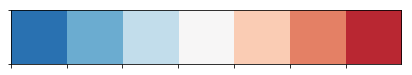

In [4]:
import seaborn as sns
sns.palplot(sns.color_palette("RdBu_r", 7))

sns.set_style("whitegrid")

# Importando base de dados

<p>Base com todos os dados do sudeste</p>

In [5]:
df = pd.read_csv('../data/sudeste.csv',low_memory=False)
print len(df)

9779168


In [6]:
df = df[df['mo'].isin([1,2,3,12])] #  somente meses do verão  DEZ a MAR
print len(df)
df.head(3)

3206856


,wsid,wsnm,elvt,lat,lon,inme,city,prov,mdct,date,...,tmin,dewp,dmax,dmin,hmdy,hmax,hmin,wdsp,wdct,gust
600,178,SÃO GONÇALO,237.0,-6.835777,-38.311583,A333,São Gonçalo,RJ,2007-12-01 00:00:00,2007-12-01,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
601,178,SÃO GONÇALO,237.0,-6.835777,-38.311583,A333,São Gonçalo,RJ,2007-12-01 01:00:00,2007-12-01,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
602,178,SÃO GONÇALO,237.0,-6.835777,-38.311583,A333,São Gonçalo,RJ,2007-12-01 02:00:00,2007-12-01,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
df = df.sort_values(['wsid', 'mdct'])
df = df.reset_index(drop=True)

In [8]:
df.head(4)

,wsid,wsnm,elvt,lat,lon,inme,city,prov,mdct,date,...,tmin,dewp,dmax,dmin,hmdy,hmax,hmin,wdsp,wdct,gust
0,178,SÃO GONÇALO,237.0,-6.835777,-38.311583,A333,São Gonçalo,RJ,2007-12-01 00:00:00,2007-12-01,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,178,SÃO GONÇALO,237.0,-6.835777,-38.311583,A333,São Gonçalo,RJ,2007-12-01 01:00:00,2007-12-01,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,178,SÃO GONÇALO,237.0,-6.835777,-38.311583,A333,São Gonçalo,RJ,2007-12-01 02:00:00,2007-12-01,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,178,SÃO GONÇALO,237.0,-6.835777,-38.311583,A333,São Gonçalo,RJ,2007-12-01 03:00:00,2007-12-01,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Pré-processamento

<h3>Limpeza dos dados</h3>

In [9]:
# Campos não numericos e campos derivados
DES= ['wsid','wsnm','elvt','lat','lon','inme','city','prov']
INT = ['yr','mo','da','hr']
DAT = ['mdct','date']
DER = ['smax','smin','tmax','tmin','dmax','dmin','hmax','hmin']

In [10]:
# dataframe apenas com os dados continuos
dfcont = df
for f in DES + INT + DAT:    
    dfcont = dfcont.drop(f, 1)

In [11]:
dfcont = dfcont.apply(pd.to_numeric, errors='coerce')  

In [12]:
dfcont.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3206856 entries, 0 to 3206855
Data columns (total 17 columns):
prcp    float64
stp     float64
smax    float64
smin    float64
gbrd    float64
temp    float64
tmax    float64
tmin    float64
dewp    float64
dmax    float64
dmin    float64
hmdy    float64
hmax    float64
hmin    float64
wdsp    float64
wdct    float64
gust    float64
dtypes: float64(17)
memory usage: 415.9 MB


In [13]:
dfcont.describe().T

,count,mean,std,min,25%,50%,75%,max
prcp,594823.0,1.244019,3.534589,0.0,0.000,0.200,0.800,100.000
stp,3206856.0,871.062130,259.613938,0.0,909.100,941.700,969.500,1050.000
smax,3206856.0,871.009694,260.134167,0.0,909.300,942.000,969.700,1049.100
smin,3206856.0,870.524392,259.991361,0.0,908.800,941.400,969.200,1048.100
gbrd,1867241.0,1327.603616,1226.852731,0.0,132.523,1030.932,2338.961,9173.064
temp,3206856.0,22.195866,7.324802,-2.8,20.200,23.000,26.300,44.900
tmax,3206841.0,17.297762,5.658299,-10.0,16.600,18.700,20.500,42.000
tmin,3206856.0,22.799069,7.576136,0.0,20.700,23.600,27.200,45.000
dewp,3206840.0,17.823554,5.776646,-10.0,17.200,19.300,21.000,44.800
dmax,3206856.0,21.616621,7.095030,-6.9,19.800,22.500,25.500,45.000


<p> A variável gbbr(radiação global) apresenta massivamente números nulos e não pode ser recuperada. Vamos retirar esta variável.</p>

In [14]:
dfcont =  dfcont.drop('gbrd',1)
df = df.drop('gbrd',1)

<p>Para as precipitações nulas foi inputado 0.0 mm. Também para o vento e rajada de vento.</p>

In [15]:
CAN_BE_NULL = ['wdsp','prcp','gust']

In [16]:
for v in CAN_BE_NULL:
    df[v] = df[v].fillna(0.0)
    dfcont[v] = dfcont[v].fillna(0.0)  

<p>Vamos ver como os dados contínuos estão organizados: MÍNIMOS, MÁXIMOS, MEDIAS</p>

In [17]:
dfcont.describe().T

,count,mean,std,min,25%,50%,75%,max
prcp,3206856.0,0.230747,1.597225,0.0,0.0,0.0,0.0,100.0
stp,3206856.0,871.062130,259.613938,0.0,909.1,941.7,969.5,1050.0
smax,3206856.0,871.009694,260.134167,0.0,909.3,942.0,969.7,1049.1
smin,3206856.0,870.524392,259.991361,0.0,908.8,941.4,969.2,1048.1
temp,3206856.0,22.195866,7.324802,-2.8,20.2,23.0,26.3,44.9
tmax,3206841.0,17.297762,5.658299,-10.0,16.6,18.7,20.5,42.0
tmin,3206856.0,22.799069,7.576136,0.0,20.7,23.6,27.2,45.0
dewp,3206840.0,17.823554,5.776646,-10.0,17.2,19.3,21.0,44.8
dmax,3206856.0,21.616621,7.095030,-6.9,19.8,22.5,25.5,45.0
dmin,3206837.0,16.782890,5.583865,-10.0,16.0,18.2,20.0,44.9


<p>A temperatura será inputada pela média</p>

In [18]:
MEAN = ['temp','dewp']

In [19]:
for v in MEAN:
    df[v] = df[v].fillna(value=df[v].median())
    dfcont[v] = dfcont[v].fillna(value=dfcont[v].median())

In [20]:
dfcont.describe().T

,count,mean,std,min,25%,50%,75%,max
prcp,3206856.0,0.230747,1.597225,0.0,0.0,0.0,0.0,100.0
stp,3206856.0,871.062130,259.613938,0.0,909.1,941.7,969.5,1050.0
smax,3206856.0,871.009694,260.134167,0.0,909.3,942.0,969.7,1049.1
smin,3206856.0,870.524392,259.991361,0.0,908.8,941.4,969.2,1048.1
temp,3206856.0,22.195866,7.324802,-2.8,20.2,23.0,26.3,44.9
tmax,3206841.0,17.297762,5.658299,-10.0,16.6,18.7,20.5,42.0
tmin,3206856.0,22.799069,7.576136,0.0,20.7,23.6,27.2,45.0
dewp,3206856.0,17.823561,5.776632,-10.0,17.2,19.3,21.0,44.8
dmax,3206856.0,21.616621,7.095030,-6.9,19.8,22.5,25.5,45.0
dmin,3206837.0,16.782890,5.583865,-10.0,16.0,18.2,20.0,44.9


In [21]:
for v in ['tmax','tmin']:
    dfcont[v] = dfcont[v].fillna(value=dfcont['temp'])
    df[v] = df[v].fillna(value=df['temp'])
for v in ['dmax','dmin']:
    dfcont[v] = dfcont[v].fillna(value=dfcont['dewp'])
    df[v] = df[v].fillna(value=df['dewp'])
for v in ['hmax','hmin']:
    dfcont[v] = dfcont[v].fillna(value=dfcont['hmdy'])
    df[v] = df[v].fillna(value=df['hmdy'])

In [22]:
dfcont.describe().T

,count,mean,std,min,25%,50%,75%,max
prcp,3206856.0,0.230747,1.597225,0.0,0.0,0.0,0.0,100.0
stp,3206856.0,871.062130,259.613938,0.0,909.1,941.7,969.5,1050.0
smax,3206856.0,871.009694,260.134167,0.0,909.3,942.0,969.7,1049.1
smin,3206856.0,870.524392,259.991361,0.0,908.8,941.4,969.2,1048.1
temp,3206856.0,22.195866,7.324802,-2.8,20.2,23.0,26.3,44.9
tmax,3206856.0,17.297780,5.658298,-10.0,16.6,18.7,20.5,42.0
tmin,3206856.0,22.799069,7.576136,0.0,20.7,23.6,27.2,45.0
dewp,3206856.0,17.823561,5.776632,-10.0,17.2,19.3,21.0,44.8
dmax,3206856.0,21.616621,7.095030,-6.9,19.8,22.5,25.5,45.0
dmin,3206856.0,16.782836,5.583923,-10.0,16.0,18.2,20.0,44.9


<h3>Derivando novas variáveis</h3>

<p>O objetivo é derivar cada variável climática contínua em uma nova variável t-1, t-2, t-3... t-n, onde n é o numeros de horas antes do momento t. Vamos primeiramente derivá-las para depois verificar quais quando massivamente as variávies estão zeradas, o que pode indicar que a estação falhou.</p>

<p>Utilizando um exemplo especifico de uma estação, depois verificamos o conjunto maior</p> 

In [23]:
dfm = df

In [24]:
len(dfm)

3206856

In [25]:
#dfm.index = pd.to_datetime(dfm.mdct)
#dfm = dfm.set_index(['mdct','wsid']).unstack().swaplevel(0,1,1).sort_index(1)
#dfm.head(4)

In [26]:
CLEAN = ['wsnm','inme','city','prov','date']
REMOVE = ['yr', 'mo', 'da', 'hr']
#REMOVE = ['wsid','yr', 'mo', 'da', 'hr']
for v in CLEAN + REMOVE:
    dfm = dfm.drop(v,1)
dfm.head(5)  

,wsid,elvt,lat,lon,mdct,prcp,stp,smax,smin,temp,...,tmin,dewp,dmax,dmin,hmdy,hmax,hmin,wdsp,wdct,gust
0,178,237.0,-6.835777,-38.311583,2007-12-01 00:00:00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,178,237.0,-6.835777,-38.311583,2007-12-01 01:00:00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,178,237.0,-6.835777,-38.311583,2007-12-01 02:00:00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,178,237.0,-6.835777,-38.311583,2007-12-01 03:00:00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,178,237.0,-6.835777,-38.311583,2007-12-01 04:00:00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
ws = dfm['wsid'].groupby(dfm['wsid']).count()
ws = list(ws.keys())
print ws

[178, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 367, 368, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423]


In [28]:
#dfm = dfm[dfm['wsid'].isin([178, 329])]
#len(dfm)

In [29]:
def df_derived_by_shift(df,lag=0,NON_DER=[]):
    df = df.copy()
    
    if not lag:
        return df
    
    cols ={}
    for i in range(1,lag+1):
        for x in list(df.columns):
            if x not in NON_DER:
                if not x in cols:
                    cols[x] = ['{}_{}'.format(x, i)]
                else:
                    cols[x].append('{}_{}'.format(x, i))
  
    for k,v in cols.items():
        columns = v
        dfn = pd.DataFrame(data=None, columns=columns, index=df.index)    
        i = 1
        for c in columns:
            dfn[c] = df[k].shift(periods=i)
            i+=1
        df = pd.concat([df, dfn], axis=1, join_axes=[df.index])
        
    return df

In [30]:
NON_DER = ['wsid','elvt','lat', 'lon', 'yr', 'mo', 'da', 'hr']

dfr = df_derived_by_shift(dfm,6,NON_DER)

In [31]:
dfr.head(4)

var = []
cld = list(dfr.columns)
for x in cld:
    if len(x.split('_')) >= 2:
        var.append((x.split('_')[0], x.split('_')[1]))

In [32]:
cols = {}
for v,i in var:
    x = '{}_{}'.format(v, i)
    if int(i) not in cols:
        cols[int(i)] = [x]
    else:
        cols[int(i)].append(x)
#print cols

In [ ]:
xxxx

In [34]:
#ws = [178,329]
#for w in ws:
#    for k,v in cols.items():
#        idx = dfr.loc[dfr['wsid']==w].index
#        dfr.loc[dfr.loc[idx,v].index[int(k)],k] = np.nan

In [70]:
for w in ws:
    idx = dfr.loc[dfr['wsid']==w].index
    x = dfr.loc[dfr['wsid']==w].iloc[0:6].index
    dfr.drop(x)

In [71]:
idx = dfr.loc[dfr['wsid']==329].index
x = dfr.loc[dfr['wsid']==329].iloc[0:6].index
dfr.loc[x]

,wsid,elvt,lat,lon,mdct,prcp,stp,smax,smin,temp,...,dmax_3,dmax_4,dmax_5,dmax_6,prcp_1,prcp_2,prcp_3,prcp_4,prcp_5,prcp_6
816792,329,854.0,-19.883945,-43.969397,2006-12-01 00:00:00,0.0,915.4,915.4,914.0,20.7,...,29.8,31.0,31.9,31.5,0.0,0.0,0.0,0.0,0.0,0.0
816793,329,854.0,-19.883945,-43.969397,2006-12-01 01:00:00,0.0,916.0,916.0,915.4,20.9,...,25.9,29.8,31.0,31.9,0.0,0.0,0.0,0.0,0.0,0.0
816794,329,854.0,-19.883945,-43.969397,2006-12-01 02:00:00,0.4,916.0,916.2,916.0,20.6,...,24.3,25.9,29.8,31.0,0.0,0.0,0.0,0.0,0.0,0.0
816795,329,854.0,-19.883945,-43.969397,2006-12-01 03:00:00,1.8,915.1,916.0,915.1,20.7,...,20.4,24.3,25.9,29.8,0.4,0.0,0.0,0.0,0.0,0.0
816796,329,854.0,-19.883945,-43.969397,2006-12-01 04:00:00,12.4,914.4,915.2,914.4,20.4,...,20.7,20.4,24.3,25.9,1.8,0.4,0.0,0.0,0.0,0.0
816797,329,854.0,-19.883945,-43.969397,2006-12-01 05:00:00,0.6,913.8,914.4,913.8,20.8,...,20.5,20.7,20.4,24.3,12.4,1.8,0.4,0.0,0.0,0.0


In [38]:
dfm = dfr

In [39]:
REMOVE = [u'prcp_1', u'prcp_2', u'prcp_3', u'prcp_4', u'prcp_5']
for v in REMOVE:
    dfm = dfm.drop(v,1)

In [40]:
dfm.columns

Index([u'wsid', u'elvt', u'lat', u'lon', u'mdct', u'prcp', u'stp', u'smax',
       u'smin', u'temp',
       ...
       u'dmin_4', u'dmin_5', u'dmin_6', u'dmax_1', u'dmax_2', u'dmax_3',
       u'dmax_4', u'dmax_5', u'dmax_6', u'prcp_6'],
      dtype='object', length=118)

In [41]:
dfm = dfm.reset_index(drop=True)

In [42]:
dfm = dfm.dropna()  

In [43]:
dfm.head(5)

,wsid,elvt,lat,lon,mdct,prcp,stp,smax,smin,temp,...,dmin_4,dmin_5,dmin_6,dmax_1,dmax_2,dmax_3,dmax_4,dmax_5,dmax_6,prcp_6
6,178,237.0,-6.835777,-38.311583,2007-12-01 06:00:00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,178,237.0,-6.835777,-38.311583,2007-12-01 07:00:00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,178,237.0,-6.835777,-38.311583,2007-12-01 08:00:00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,178,237.0,-6.835777,-38.311583,2007-12-01 09:00:00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,178,237.0,-6.835777,-38.311583,2007-12-01 10:00:00,0.0,986.3,986.3,985.7,25.4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
# como esta rede é especifica para a BH, vamos remover elvt, lat, lon
#REMOVE = ['elvt','lat', 'lon']
#for v in REMOVE:
#    dfm = dfm.drop(v,1)

In [45]:
dfm.head(5)

,wsid,elvt,lat,lon,mdct,prcp,stp,smax,smin,temp,...,dmin_4,dmin_5,dmin_6,dmax_1,dmax_2,dmax_3,dmax_4,dmax_5,dmax_6,prcp_6
6,178,237.0,-6.835777,-38.311583,2007-12-01 06:00:00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,178,237.0,-6.835777,-38.311583,2007-12-01 07:00:00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,178,237.0,-6.835777,-38.311583,2007-12-01 08:00:00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,178,237.0,-6.835777,-38.311583,2007-12-01 09:00:00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,178,237.0,-6.835777,-38.311583,2007-12-01 10:00:00,0.0,986.3,986.3,985.7,25.4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
CAN_BE_NULL

['wdsp', 'prcp', 'gust']

<h3>Preparando a base</h3>

<p>Removendo registros que não pode ser nulos e prejudicariam o treinamento</p>

In [47]:
cols = list(dfm.columns)

COLS_BE_NULL = ['prcp','wdsp','wdsp_1','wdsp_2','wdsp_3','wdsp_4','wdsp_5',\
                'gust','gust_1','gust_2','gust_3','gust_4','gust_5']
for v in COLS_BE_NULL:
    if v in cols:
        cols.remove(v)

In [48]:
dfm[cols] = dfm[cols].replace({0.0:np.nan})
dfm.head(5)

,wsid,elvt,lat,lon,mdct,prcp,stp,smax,smin,temp,...,dmin_4,dmin_5,dmin_6,dmax_1,dmax_2,dmax_3,dmax_4,dmax_5,dmax_6,prcp_6
6,178,237.0,-6.835777,-38.311583,2007-12-01 06:00:00,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,178,237.0,-6.835777,-38.311583,2007-12-01 07:00:00,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,178,237.0,-6.835777,-38.311583,2007-12-01 08:00:00,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,178,237.0,-6.835777,-38.311583,2007-12-01 09:00:00,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,178,237.0,-6.835777,-38.311583,2007-12-01 10:00:00,0.0,986.3,986.3,985.7,25.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
dfm = dfm.dropna()

In [50]:
len(dfm)

269935

In [51]:
dfm.head(5)

,wsid,elvt,lat,lon,mdct,prcp,stp,smax,smin,temp,...,dmin_4,dmin_5,dmin_6,dmax_1,dmax_2,dmax_3,dmax_4,dmax_5,dmax_6,prcp_6
1385,178,237.0,-6.835777,-38.311583,2008-01-27 17:00:00,0.0,983.1,983.7,983.1,29.0,...,21.8,21.8,22.1,27.6,26.3,25.3,24.1,24.1,23.3,0.2
1985,178,237.0,-6.835777,-38.311583,2008-02-21 17:00:00,0.0,983.5,984.3,983.5,30.9,...,21.2,21.7,21.3,30.5,29.4,28.0,26.8,25.6,24.6,0.2
2130,178,237.0,-6.835777,-38.311583,2008-02-27 18:00:00,0.0,983.2,984.2,983.2,28.3,...,22.0,22.4,22.0,27.4,26.2,24.9,24.5,23.6,23.6,1.0
2131,178,237.0,-6.835777,-38.311583,2008-02-27 19:00:00,0.0,982.2,983.2,982.2,27.5,...,21.9,22.0,22.4,27.3,27.4,26.2,24.9,24.5,23.6,0.2
2159,178,237.0,-6.835777,-38.311583,2008-02-28 23:00:00,0.0,983.1,983.1,981.9,25.6,...,20.0,20.4,19.9,23.4,23.7,30.5,31.5,30.9,28.9,0.2


In [52]:
dfm.describe().T

,count,mean,std,min,25%,50%,75%,max
wsid,269935.0,357.524345,37.532617,178.000000,325.000000,353.000000,393.000000,423.000000
elvt,269935.0,654.589205,395.427064,3.000000,432.000000,660.000000,931.000000,1758.000000
lat,269935.0,-20.606684,2.314947,-24.962819,-22.395799,-20.762607,-19.481935,-6.835777
lon,269935.0,-45.099086,2.815650,-51.408637,-47.382549,-44.961909,-42.987146,-38.311583
prcp,269935.0,0.593032,2.143064,0.000000,0.000000,0.000000,0.200000,78.400000
stp,269935.0,939.603183,42.838287,816.900000,908.800000,938.400000,963.600000,1047.200000
smax,269935.0,939.857269,42.842285,817.100000,909.100000,938.600000,963.900000,1047.800000
smin,269935.0,939.338119,42.843443,816.900000,908.600000,938.100000,963.300000,1045.100000
temp,269935.0,21.560578,3.144528,7.000000,19.600000,21.300000,23.300000,39.700000
tmax,269935.0,19.254994,2.178657,-8.400000,18.000000,19.400000,20.800000,34.700000


In [53]:
 dfm = dfm.drop('wsid',1)

<h3>Balanceamento</h3>

<p>Preparação para o balanceamento</p>

In [54]:
#from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [55]:
def f(x):
    if x['prcp'] == 0.0: 
        return 0
    else:        
        return 1    

In [56]:
dfm['type'] = dfm.apply(f,axis=1)

In [57]:
dfm.head(3)

,elvt,lat,lon,mdct,prcp,stp,smax,smin,temp,tmax,...,dmin_5,dmin_6,dmax_1,dmax_2,dmax_3,dmax_4,dmax_5,dmax_6,prcp_6,type
1385,237.0,-6.835777,-38.311583,2008-01-27 17:00:00,0.0,983.1,983.7,983.1,29.0,22.5,...,21.8,22.1,27.6,26.3,25.3,24.1,24.1,23.3,0.2,0
1985,237.0,-6.835777,-38.311583,2008-02-21 17:00:00,0.0,983.5,984.3,983.5,30.9,18.9,...,21.7,21.3,30.5,29.4,28.0,26.8,25.6,24.6,0.2,0
2130,237.0,-6.835777,-38.311583,2008-02-27 18:00:00,0.0,983.2,984.2,983.2,28.3,21.5,...,22.4,22.0,27.4,26.2,24.9,24.5,23.6,23.6,1.0,0


In [58]:
#Criando bins sem chuva(0mm), com poquisima chuva( até 0.1mm), chuva fraca (> 0.1 até 1.0) \
#e depois agrupando de 5 em 
#bins = np.linspace(dfm.prcp.min(), dfm.prcp.max(), 10)
#bins = [0,0.1,1,5,10,15,20,25,30] 
#types = np.digitize(dfm.prcp, bins)  
#dfm['type'] = types

In [59]:
z = dfm['type'].groupby(dfm['type']).count()
print (z)

type
0    182113
1     87822
Name: type, dtype: int64


<h2>Mineiração dos dados</h2>

<h3>Rede neural</h3>

In [60]:
import tensorflow as tf  
from sklearn.metrics import explained_variance_score, mean_absolute_error,  median_absolute_error
from sklearn.model_selection import train_test_split 

In [61]:
#dfm = dfm.drop('prcp',1)

In [62]:
target = 'type'

In [63]:
X = dfm[[col for col in dfm.columns if col != target]]

In [64]:
y = dfm[target]

In [65]:
X.head(5)

,elvt,lat,lon,mdct,prcp,stp,smax,smin,temp,tmax,...,dmin_4,dmin_5,dmin_6,dmax_1,dmax_2,dmax_3,dmax_4,dmax_5,dmax_6,prcp_6
1385,237.0,-6.835777,-38.311583,2008-01-27 17:00:00,0.0,983.1,983.7,983.1,29.0,22.5,...,21.8,21.8,22.1,27.6,26.3,25.3,24.1,24.1,23.3,0.2
1985,237.0,-6.835777,-38.311583,2008-02-21 17:00:00,0.0,983.5,984.3,983.5,30.9,18.9,...,21.2,21.7,21.3,30.5,29.4,28.0,26.8,25.6,24.6,0.2
2130,237.0,-6.835777,-38.311583,2008-02-27 18:00:00,0.0,983.2,984.2,983.2,28.3,21.5,...,22.0,22.4,22.0,27.4,26.2,24.9,24.5,23.6,23.6,1.0
2131,237.0,-6.835777,-38.311583,2008-02-27 19:00:00,0.0,982.2,983.2,982.2,27.5,21.6,...,21.9,22.0,22.4,27.3,27.4,26.2,24.9,24.5,23.6,0.2
2159,237.0,-6.835777,-38.311583,2008-02-28 23:00:00,0.0,983.1,983.1,981.9,25.6,21.9,...,20.0,20.4,19.9,23.4,23.7,30.5,31.5,30.9,28.9,0.2


<p>Separando o conjunto de treinamento e validação (metade dos 30% separados para validação)</p>

In [66]:
X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size=0.3, random_state=12) 

<p>Executando o balanceamento</p>

In [67]:
from sklearn.decomposition import PCA

In [68]:
pca = PCA(n_components=2)

In [69]:
X_vis = pca.fit_transform(X_train)

ValueError: invalid literal for float(): 2006-12-27 23:00:00

In [ ]:
rus = RandomUnderSampler(return_indices=True)
X_resampled, y_resampled, idx_resampled = rus.fit_sample(X_train, y_train)
X_res_vis = pca.transform(X_resampled)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
idx_samples_removed = np.setdiff1d(np.arange(X_vis.shape[0]),
                                   idx_resampled)

idx_class_0 = y_resampled == 0
plt.scatter(X_res_vis[idx_class_0, 0], X_res_vis[idx_class_0, 1],
            alpha=.8, label=u'Sem precipitação')
plt.scatter(X_res_vis[~idx_class_0, 0], X_res_vis[~idx_class_0, 1],
            alpha=.8, label=u'Com precipitação')
plt.scatter(X_vis[idx_samples_removed, 0], X_vis[idx_samples_removed, 1],
            alpha=.8, label='Removidos')

# make nice plotting
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))
#ax.set_xlim([-6, 6])
#ax.set_ylim([-6, 6])

plt.title('Under-sampling using random under-sampling')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
#X_train_over, y_train_over =  SMOTE(random_state=12).fit_sample(X_train, y_train)

In [ ]:
len(X_resampled), len(y_resampled)

<p>Reconstruindo o dataframe</p>

In [ ]:
#X_train = pd.DataFrame(X_train_over, columns = X_train.columns)
X_train = pd.DataFrame(X_resampled, columns = X_train.columns)

In [ ]:
#y_train = pd.DataFrame(y_train_over, columns =['type'])
y_train = pd.DataFrame(y_resampled, columns =['type'])

In [ ]:
X_train.head()

In [ ]:
#Como o balanceamento SMOTE não serve valores continuos, eu criei classes de chuvas, \
#mas o objetivo ainda persiste em prever o volume de precipitação. Assim vou colocar como alvo a precipitação

<p>Reconstruindo o datafram para alimnar o tensorflow</p>

In [ ]:
y_train['prcp'] = X_train['prcp']
y_tmp = X_tmp['prcp']

In [ ]:
y_train = y_train.drop('type',1)

In [ ]:
X_train = X_train.drop('prcp',1)
X_tmp = X_tmp.drop('prcp',1)

In [ ]:
X_tmp.head(3)

<p>Separando o conjunto de testes</p>

In [ ]:
target = 'prcp'

In [ ]:
X_test, X_val, y_test, y_val = train_test_split(X_tmp, y_tmp, test_size=0.5)

In [ ]:
X_train.shape, X_test.shape, X_val.shape  
print("Training instances   {}, Training features   {}".format(X_train.shape[0], X_train.shape[1]))  
print("Validation instances {}, Validation features {}".format(X_val.shape[0], X_val.shape[1]))  
print("Testing instances    {}, Testing features    {}".format(X_test.shape[0], X_test.shape[1]))  

In [ ]:
# Zarate instructions
st_units = (X_train.shape[1] * 2) + 1
sd_units = X_train.shape[1] 
#activation_fn = tf.sigmoid
batch_size = 1000
up = int(len(X_train)/batch_size)

In [ ]:
up

In [ ]:
feature_cols = [tf.feature_column.numeric_column(col) for col in X_train.columns] 

In [ ]:
regressor = tf.estimator.DNNRegressor(feature_columns=feature_cols,  
                                      hidden_units=[st_units,sd_units],
                                     # activation_fn=activation_fn,
                                      model_dir='/tmp/tf_wx_model-19')

In [ ]:
def wx_input_fn(X, y=None, num_epochs=None, shuffle=True, batch_size=batch_size):  
    return tf.estimator.inputs.pandas_input_fn(x=X,
                                               y=y,
                                               num_epochs=num_epochs,
                                               shuffle=shuffle,
                                               batch_size=batch_size)

In [ ]:
evaluations = []  
STEPS = 500  
for i in range(1, up):  
    regressor.train(input_fn=wx_input_fn(X_train, y=y_train), steps=STEPS)
    evaluations.append(regressor.evaluate(input_fn=wx_input_fn(X_val,
                                                               y_val,
                                                               num_epochs=1,
                                                               shuffle=False)))

In [ ]:
import matplotlib.pyplot as plt  
%matplotlib inline

plt.rcParams['figure.figsize'] = [15, 10]

loss_values = [ev['loss'] for ev in evaluations]  
training_steps = [ev['global_step'] for ev in evaluations]

plt.scatter(x=training_steps, y=loss_values)  
plt.xlabel('Training steps')  
plt.ylabel('Loss (SSE)')  
plt.show()  

In [ ]:
pred = regressor.predict(input_fn=wx_input_fn(X_test,  
                                              num_epochs=1,
                                              shuffle=False))

predictions = np.array([p['predictions'][0] for p in pred])

In [ ]:

print("The Explained Variance: %.2f" % explained_variance_score(  
                                            y_test, predictions))  
print("The Mean Absolute Error: %.2f mm " % mean_absolute_error(  
                                            y_test, predictions))  
print("The Median Absolute Error: %.2f mm" % median_absolute_error(  
                                            y_test, predictions))

In [ ]:
predictions

In [ ]:
predictions.size

In [ ]:
fig, ax = plt.subplots()
ax.scatter(y_test, predictions, edgecolors=(0, 0, 0))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()